## Step 1 - Climate Analysis and Exploration:
---------------------------------------------------------------

In [1]:
# Importing dependencies:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Ignoring SQLITE warnings:
import warnings
warnings.filterwarnings('ignore')

## Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Creating the engine to connect to the database:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [4]:
# Reflecting an existing database into a new model:
Base = automap_base()

# Reflecting the tables:
Base.prepare(engine, reflect=True)

# Viewing all of the classes that automap found:
Base.classes.keys()

['measurement', 'station']

In [5]:
# Saving references to each table:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Using 'inspect' to explore the database and print the table names:
# Same results as reflecting an existing DB using 'automap_base' (not necessary I just wanted to run it)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Using 'inspector' to print the column names within the 'measurement' table and its datatypes:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Using 'inspector' to print the column names within the 'station' table and its datatypes:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Creating our session (link) from Python to the DB:
session = Session(engine)

## Exploratory Climate Analysis

### Precipitation Analysis:

In [10]:
# Finding the last date in the dataset:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [11]:
# Calculating the date of 1 year ago from the last data point in the database:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [12]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results:
last_12_mos = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).order_by(Measurement.date.desc()).statement

In [13]:
# Saving the query results as a Pandas DataFrame and set the index to the date column:
prcp_df = pd.read_sql_query(last_12_mos, session.bind)
prcp_dates = prcp_df.set_index("date")

In [14]:
# Sorting the dataframe by date using pandas, setting the index as the 'date' column:
prcp_dates.sort_values(["date"], ascending=True, inplace=True)
prcp_dates

,prcp
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


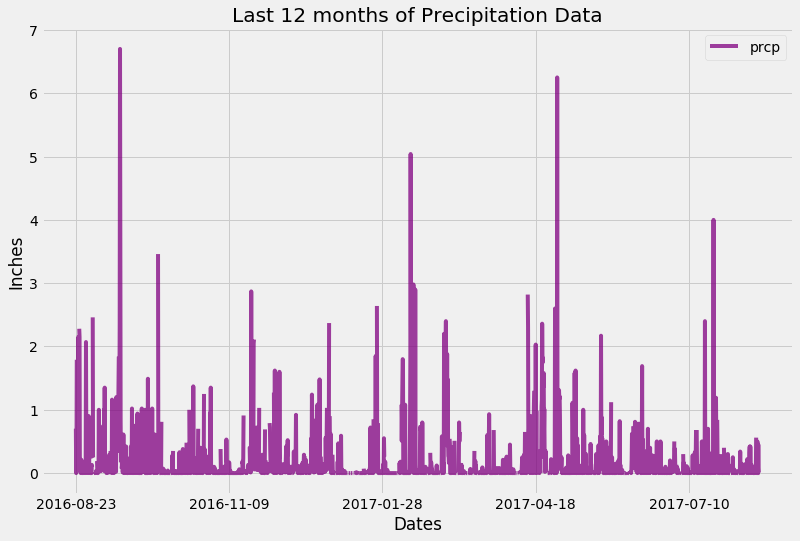

In [15]:
# Using Pandas Plotting with Matplotlib to plot the data:
plot = prcp_dates.plot(title="Last 12 months of Precipitation Data", figsize=(12,8), color='purple', alpha=0.75)
plot.set_xlabel("Dates")
plot.set_ylabel("Inches")
plt.show()

In [16]:
# Using Pandas to calcualte the summary statistics for the precipitation data:
prcp_dates.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis:

In [17]:
# Designing a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station).count()
num_of_stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order:
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the 'most active station'?

# The 'most active station' resulted to be = 'USC00519281' found from the previous query. 

# Now we find the lowest temp, highest temp, and avg temp recorded in this query:
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

selected_station = session.query(*sel).filter(Measurement.station == 'USC00519281').statement

sel_station_df = pd.read_sql_query(selected_station, session.bind)
sel_station_df.rename(columns={
    "station": "Station", "min_1": "Lowest Temperature", 
    "max_1": "Highest Temperature", 
    "avg_1": "Average Temperature"}, inplace=True)
sel_station_df


,Station,Lowest Temperature,Highest Temperature,Average Temperature
0,USC00519281,54.0,85.0,71.663781


In [20]:
# Choosing the station with the highest number of temperature observations
# Querying the last 12 months of temperature observation data (TOBS) for this station and plot the results as a histogram:
tobs_sel_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= query_date).order_by(Measurement.date.desc()).filter(Measurement.station == 'USC00519281').statement

In [21]:
# Saving the query results as a Pandas DataFrame and set the index to the date column:
tobs_sel_station = pd.read_sql_query(tobs_sel_station, session.bind)
tobs_dates = tobs_sel_station.set_index("date")

In [22]:
# Sorting the dataframe by date using pandas, setting the index as the 'date' column:
tobs_dates.sort_values(["date"], ascending=True, inplace=True)
tobs_dates

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


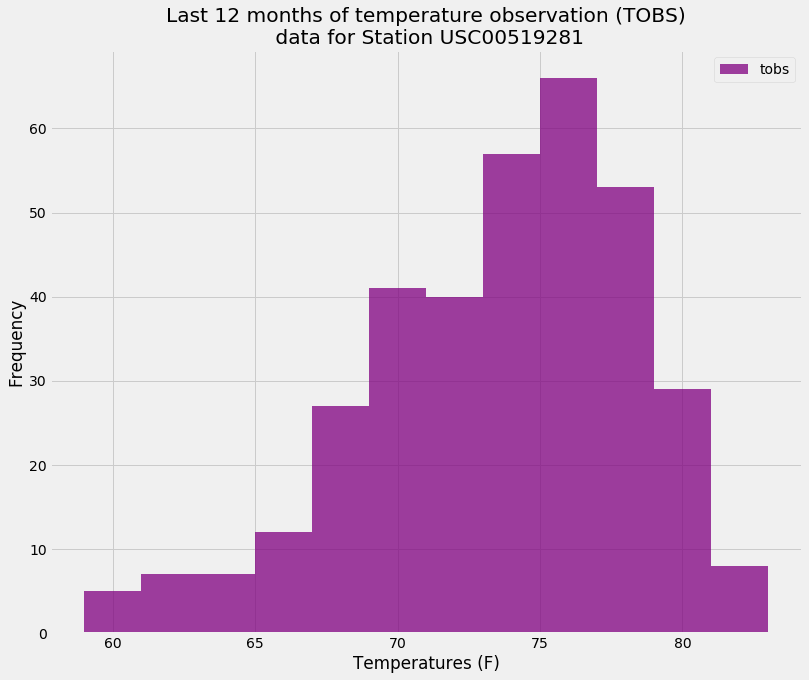

In [23]:
# Creating the histogram from the results:
temp_plot = tobs_dates.plot(kind='hist', bins=12, 
                            title="Last 12 months of temperature observation (TOBS)\n data for Station USC00519281", 
                            figsize=(12,10), color='purple', alpha=0.75)
temp_plot.set_xlabel("Temperatures (F)")
temp_plot.set_ylabel("Frequency")
plt.show()